# top 10 kmer in IAP v.s. genome (1kb-bin)

In [1]:
import os
import subprocess
import gzip
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [3]:
kmer_ls = pd.read_csv(
    '/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/top10andZfp57meth_kmer_frequency.tsv',
    sep = "\t", header = 0, 
).columns.tolist()[1:]
kmer_ls

['AGA',
 'CAC',
 'AAG',
 'CACC',
 'GTAAA',
 'AAAG',
 'CCC',
 'ATTAG',
 'ATTC',
 'ATCAG',
 'TGCmCGC']

In [5]:
%%bash
cd /mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers/1kbBin/
IAP_bed=/mnt/Storage/home/wangyiman/annotations/mm10/Repeats/LTR/ERVK/mm10_euch.IAPEz-int.merged.bed
genome_bed=/mnt/Storage/home/wangyiman/annotations/mm10/mm10_euch.chrom.limits
bedtools makewindows -b $IAP_bed -w 1000 > IAPEzint_1kbBin.bed
bedtools makewindows -b <(awk 'BEGIN{FS=OFS="\t"}{print $1,$2-1,$3}' $genome_bed) -w 1000 > genomeEu_1kbBin.bed



In [6]:
%%bash

### not used
cd /mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers/1kbBin
IAP_1kb_bed=IAPEzint_1kbBin.bed
genome_1kb_bed=genomeEu_1kbBin.bed
fa_bed=/mnt/Storage/home/wangyiman/annotations/mm10/mm10.fa

bedtools getfasta -fi $fa_bed -bed $IAP_1kb_bed > mm10_euch.IAPEz-int1kb.merged.fa
bedtools getfasta -fi $fa_bed -bed $genome_1kb_bed > mm10_euch.genome1kb.merged.fa

Process is interrupted.


In [8]:
%%bash
### kmer frequency in IAPEz sequence
cd /mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers/1kbBin
for kmer in $(head -1 ../../top10andZfp57meth_kmer_frequency.tsv | cut -f 2-11);do
    echo $kmer
    get_Kmer_frequency.py $kmer IAPEzint_1kbBin.bed IAPEzint1kb_top10kmer_freq_${kmer}.bed /mnt/Storage/home/wangyiman/annotations/mm10/mm10.2bit
done

AGA
CAC
AAG
CACC
GTAAA
AAAG
CCC
ATTAG
ATTC
ATCAG


In [40]:
%%bash 
### kmer frequency in genome-wide (background)
### runned in runned_tmp6.sh in tmux
cd /mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers/1kbBin
for kmer in $(head -1 ../../top10andZfp57meth_kmer_frequency.tsv | cut -f 2-11);do
    echo $kmer
    get_Kmer_frequency.py $kmer genomeEu_1kbBin.bed genomeEuch_top10kmer_freq_${kmer}.bed /mnt/Storage/home/wangyiman/annotations/mm10/mm10.2bit
done

In [16]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers/1kbBin')
top10kmer_freq = pd.DataFrame()

for kmer in kmer_ls[:-1] :
    for region in ['IAPEzint1kb', 'genomeEuch'] : 
        df = pd.read_csv(f'{region}_top10kmer_freq_{kmer}.bed', sep = "\t", usecols = ['Mean_Kmer_Ratio'])
        df["kmer"] = kmer 
        df["region"] = region
        top10kmer_freq = pd.concat([top10kmer_freq, df])
        

In [24]:
top10kmer_freq['Count per kb'] = top10kmer_freq['Mean_Kmer_Ratio'] * 1000
top10kmer_freq

,Mean_Kmer_Ratio,kmer,region,Count per Kb,Count per kb
0,0.024500,AGA,IAPEzint1kb,24.500000,24.500000
1,0.029528,AGA,IAPEzint1kb,29.527559,29.527559
2,0.033877,AGA,IAPEzint1kb,33.877039,33.877039
3,0.023810,AGA,IAPEzint1kb,23.809524,23.809524
4,0.052632,AGA,IAPEzint1kb,52.631579,52.631579
...,...,...,...,...,...
2462750,0.000000,ATCAG,genomeEuch,0.000000,0.000000
2462751,0.000000,ATCAG,genomeEuch,0.000000,0.000000
2462752,0.000000,ATCAG,genomeEuch,0.000000,0.000000
2462753,0.000000,ATCAG,genomeEuch,0.000000,0.000000


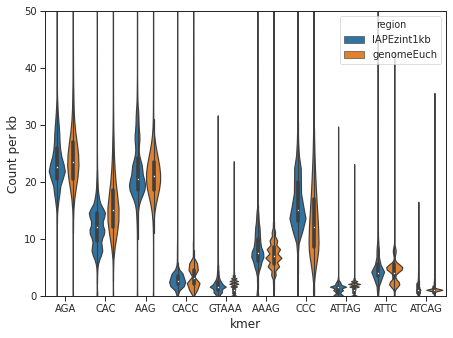

In [25]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize = (6.4, 4.8), tight_layout = True)
    sns.violinplot(
        data = top10kmer_freq,
        y = "Count per kb",
        x = "kmer",
        hue = "region",
        
    )
    ax.set_ylim(0,50)
    

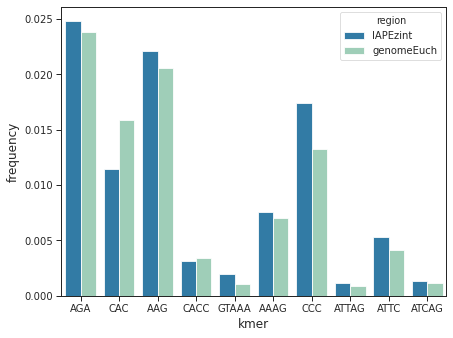

In [47]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize = (6.4, 4.8), tight_layout = True)
    sns.barplot(
        data = top10kmer_freq_df,
        y = 'frequency',
        x = 'kmer', 
        hue = 'region',
        palette = 'YlGnBu_r',
        orient = 'v')
    # ax.set_xlim(0,20000)
#     ax.set_xscale('log')
    # ax.set_xlabel('Number of peaks')
    fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make10_bar_top10kmerFreq_IAP_genome.pdf',transparent=True)
     
